In [9]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [1]:
import sys, os

os.environ["JAX_ENABLE_X64"] = "True"
os.environ["JAX_PLATFORM_NAME"] = "CPU"
from pathlib import Path
from pprint import pprint
import matplotlib.pyplot as plt, numpy as np
from jax import numpy as jnp, jit, jacobian
#from jfi import jaxm
#from jfi.experimental.jit import autojit, nestedautojit

root_path = Path("").absolute().parent
if str(root_path) not in sys.path:
    sys.path.insert(0, str(root_path))
from pmpc.experimental.jax.root import (
    linearly_approximate,
    linear_optimality,
    rollout_approximate,
    masked_rollout_approximate,
    compute_sensitivity_L,
    all_sensitivity_L,
)
from pmpc.scp_mpc import solve
from pmpc import Problem

In [2]:
def car(x, u, p):
    """
    unicycle car dynamics, 4 states, 2 actions
    x1: position x
    x2: position y
    x3: speed (local frame)
    x4: orientation angle

    u1: acceleration
    u2: turning speed (independent of velocity)
    """
    assert x.shape[-1] == 4 and u.shape[-1] == 2
    v_scale, w_scale, T = p[..., 0], p[..., 1], p[..., 2]
    eps = 1e-6
    u1, u2 = v_scale * u[..., 0], w_scale * -u[..., 1]
    u1 = u1 + jnp.where(u1 >= 0.0, eps, -eps)
    u2 = u2 + jnp.where(u2 >= 0.0, eps, -eps)

    x0, y0, v0, th0 = x[..., 0], x[..., 1], x[..., 2], x[..., 3]
    xp1 = (
        x0
        + (
            u2 * jnp.sin(T * u2 + th0) * v0
            + T * u1 * u2 * jnp.sin(T * u2 + th0)
            + u1 * jnp.cos(T * u2 + th0)
        )
        / u2**2
        - (jnp.sin(th0) * u2 * v0 + jnp.cos(th0) * u1) / u2**2
    )
    xp2 = (
        y0
        - (
            u2 * jnp.cos(T * u2 + th0) * v0
            - u1 * jnp.sin(T * u2 + th0)
            + T * u1 * u2 * jnp.cos(T * u2 + th0)
        )
        / u2**2
        + (jnp.cos(th0) * u2 * v0 - jnp.sin(th0) * u1) / u2**2
    )
    xp3 = v0 + T * u1
    xp4 = T * u2 + th0
    xp = jnp.stack([xp1, xp2, xp3, xp4], -1)
    return xp


def fx_(x, u, p):
    sum_dims = range(0, x.ndim - 1)
    return jnp.moveaxis(jacobian(lambda x: jnp.sum(car(x, u, p), sum_dims))(x), 0, -2)


def fu_(x, u, p):
    sum_dims = range(0, x.ndim - 1)
    return jnp.moveaxis(jacobian(lambda u: jnp.sum(car(x, u, p), sum_dims))(u), 0, -2)


@jit
def f_fx_fu_fn(x, u, p=None):
    if p is None:
        p = jnp.array([1.0, 1.0, 0.3])
    return car(x, u, p), fx_(x, u, p), fu_(x, u, p)


In [24]:
p = Problem(N=50, xdim=4, udim=2, f_fx_fu_fn=f_fx_fu_fn)
p.X_ref = np.ones(p.xdim)
X_ref2 = 3 * np.ones(p.X_ref.shape)


def lin_cost_fn(x, u, problem):
    return (x - X_ref2), None

p.lin_cost_fn = lin_cost_fn


In [28]:
X, U, _ = solve(**p)

+------+------------+------------+------------+------------+------------+
|  it  |   elaps    |    obj     |   resid    |   reg_x    |   reg_u    |
+------+------------+------------+------------+------------+------------+
| 0001 |  7.179e-03 |  3.858e+00 |  4.308e+00 |  1.000e+00 |  1.000e+00 |
| 0002 |  1.369e-02 |  3.453e+00 |  4.280e+00 |  1.000e+00 |  1.000e+00 |
| 0003 |  2.004e-02 |  3.894e+00 |  1.077e+00 |  1.000e+00 |  1.000e+00 |
| 0004 |  2.673e-02 |  3.891e+00 |  4.899e-01 |  1.000e+00 |  1.000e+00 |
| 0005 |  3.376e-02 |  3.934e+00 |  3.050e-01 |  1.000e+00 |  1.000e+00 |
| 0006 |  4.046e-02 |  3.953e+00 |  2.110e-01 |  1.000e+00 |  1.000e+00 |
| 0007 |  4.586e-02 |  3.965e+00 |  1.552e-01 |  1.000e+00 |  1.000e+00 |
| 0008 |  5.118e-02 |  3.973e+00 |  1.172e-01 |  1.000e+00 |  1.000e+00 |
| 0009 |  5.658e-02 |  3.979e+00 |  9.010e-02 |  1.000e+00 |  1.000e+00 |
| 0010 |  6.174e-02 |  3.984e+00 |  7.019e-02 |  1.000e+00 |  1.000e+00 |
| 0011 |  6.703e-02 |  3.987e+00 |  5.

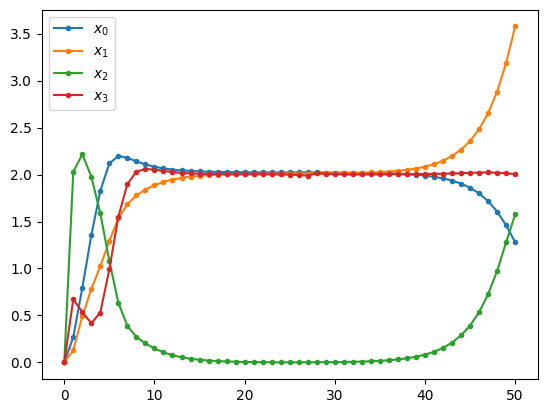

In [29]:
plt.figure()
for i in range(X.shape[-1]):
    plt.plot(X[:, i], label=f"$x_{i}$", marker=".")
plt.legend()
plt.show()